# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- scipy: https://scipy.org/install/
- gym: https://github.com/openai/gym 

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

# Implementation of the Windy GridWorld environment in Example 6.5

In [189]:
import numpy as np
import random
from collections import defaultdict
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

In [190]:
"""Windy GridWorld Env"""
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        """
        Args:
            enable_king_move (bool): If True, using King's movement. Otherwise, using the original action space.
            enable_no_move (bool): If True, adding no movement under the condition of enable_king_move = True.
        
        Note: for different setup, we have the following action spaces:
            - Original: ["up", "down", "left", "right"];
            - King's move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right"];
            - King's move + no move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right", "stay"]
        """
        
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space
        if enable_king_move:
            # add King's move actions
            if enable_no_move:
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1]),  # add down-left
                    "stay": np.array([0, 0])  # add no move action
                }
            else:
                # add King's move actions + one no movement action
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1])  # add down-left
                }
        else:
            # normal actions
            self.action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }

        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):
        """
        Args:
            act (string): a string variable indicating the action.
        """
        # obtain the state array
        s_arr = np.array(self.state)

        # obtain the action array
        act_arr = self.action_space[act.lower()]

        # obtain the wind array
        wind_arr = -1 * np.array([self.wind[self.state[1]], 0], dtype=int)

        # compute the next state
        next_s_arr = np.clip(s_arr + act_arr + wind_arr,
                             a_min=np.array([0, 0]),
                             a_max=np.array([self.grid.shape[0]-1, self.grid.shape[1]-1]))

        # compute the reward
        reward = 0 if next_s_arr.tolist() == self.goal_state else -1

        # check the termination
        terminated = True if reward == 0 else False

        # update the tracking variables
        self.state = next_s_arr.tolist()
        self.t += 1
        self.act = act

        return self.state, reward, terminated

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)

In [191]:
"""Plot function similar to Ex1"""
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))
    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        y = list(range(1,len(arr)+1))
        arr_err = np.std(y) / np.sqrt(len(y))
        # plot the mean
        h, = ax.plot(arr, y, color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(arr, (y - arr_err), (y + arr_err), color=color, alpha=0.3)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)
    plt.show()

# Test Windy GridWorld 

In [192]:
# check whether enable King's movement and no movement
use_king_move = False
use_no_move = False

# create the environment
env = WindyGridWorld(enable_king_move=use_king_move,
                     enable_no_move=use_no_move)
s, d = env.reset()

# iteracting with the environment for 10 time steps using a random policy
for t in range(10): 
    # sample an random action
    a = np.random.choice(list(env.action_space.keys()), 1)[0]
    
    # interact with the envrionment
    next_s, r, d = env.step(action)
    
    # print info
    print(f"t = {t}: state = {s}, action = {a},  reward = {r}, next_state = {next_s}, done = {d}")
    
    # check termination
    if d:
        s, d = env.reset()

NameError: name 'action' is not defined

# Q4 - (a): Solve the Windy Gridworld using the following algorithms and reproduce the figure similar to the figure in Example 6.5

- Implement the SARSA, Expected SARSA, and Q learning.
- Reproduce the plot in the Example 6.5 and plot the three curves in a single plot. You can use the provided plotting code.

In [322]:
def epsilon_greedy_policy_impl(S, Q, epsilon, action_space, policy):
    final_action = random.choice(action_space)
    max_actions = []
    policy[S] = {}
    expected_Q = 0
    for action in action_space:
        if Q[S,action] > Q[S ,final_action]:
            final_action = action
            max_actions = [final_action]
        elif Q[S, action] == Q[S , final_action]:
            max_actions.append(action)
        #setting all action probability for s under policy to epsilon/|A|
        policy[S][action] = epsilon/len(action_space)
        # precalculating the value of state S for expected sarasa
        expected_Q += policy[S][action]*Q[S,action]
    # Rendom tie breaks between best actions
    final_action = random.choice(max_actions)
    #setting best action's probability of selection
    policy[S][final_action]  +=  1 - epsilon
    expected_Q += policy[S][final_action]*Q[S,final_action] - (epsilon/len(action_space))*Q[S,final_action]
    # returning epsilon greedy action from the policy
    return np.random.choice(list(policy[S].keys()), 1, p=list(policy[S].values()))[0], expected_Q

In [323]:
""" CODE HERE YOUR IMPLEMENTATION for SARSA """
def sarsa(trial_num, n_episodes, step, epsilon, enable_king_move, enable_no_move): 
    grid_world = WindyGridWorld(enable_king_move, enable_no_move)
    steps_per_episode = [0]*n_episodes
    cumulative_time_steps = [0]
    for e in tqdm.tqdm(range(trial_num), desc="Run trail", position=0):
        Q = defaultdict(float)
        policy = {}
        for state in grid_world.state_space:
            for action in grid_world.action_space:
                if state == grid_world.goal_state:
                    Q[tuple(state) , action] = 0
                else:
                    Q[tuple(state), action] = 0
        for r in tqdm.tqdm(range(n_episodes), desc="run number", position=0):
            S, terminated = grid_world.reset()
            S = tuple(S)
            A, _ = epsilon_greedy_policy_impl(S, Q, epsilon, list(grid_world.action_space.keys()), policy)
            time_steps = 0
            while True:    
                S_prime , R, terminated = grid_world.step(A)
                time_steps += 1
                S_prime = tuple(S_prime)
                A_prime, _ = epsilon_greedy_policy_impl(S_prime, Q, epsilon, list(grid_world.action_space.keys()), policy)
                Q[S, A] += step*(R + Q[S_prime, A_prime] - Q[S, A])
                if terminated:
                    break
                S, A = S_prime, A_prime
            steps_per_episode[r] += time_steps
    for step in steps_per_episode:
        cumulative_time_steps.append(cumulative_time_steps[-1]+step/trial_num)
    return cumulative_time_steps, Q

In [324]:
cumulative_time_steps_sarsa,_ = sarsa(10,200, 0.5, 0.1, False, False)

Run trail:   0%|          | 0/10 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

In [325]:
""" CODE HERE YOUR IMPLEMENTATION for Expected SARSA """
def expected_sarsa(trial_num, n_episodes, step, epsilon, enable_king_move, enable_no_move):
    grid_world = WindyGridWorld(enable_king_move, enable_no_move)
    steps_per_episode = [0]*n_episodes
    cumulative_time_steps = [0]
    for e in tqdm.tqdm(range(trial_num), desc="Run trail", position=0):
        Q = defaultdict(float)
        policy = {}
        for state in grid_world.state_space:
            for action in grid_world.action_space:
                if state == grid_world.goal_state:
                    Q[tuple(state) , action] = 0
                else:
                    Q[tuple(state), action] = 0
        for r in tqdm.tqdm(range(n_episodes), desc="run number", position=0):
            S, terminated = grid_world.reset()
            S = tuple(S)
            time_steps = 0
            while True: 
                A, _ = epsilon_greedy_policy_impl(S, Q, epsilon, list(grid_world.action_space.keys()), policy)
                S_prime , R, terminated = grid_world.step(A)
                time_steps += 1
                S_prime = tuple(S_prime)
                _, expected_Q = epsilon_greedy_policy_impl(S_prime, Q, epsilon, list(grid_world.action_space.keys()), policy)
                Q[S, A] += step*(R + expected_Q - Q[S, A])
                if terminated:
                    break
                S = S_prime
            steps_per_episode[r] += time_steps
    for step in steps_per_episode:
        cumulative_time_steps.append(cumulative_time_steps[-1]+step/trial_num)
    return cumulative_time_steps, Q

In [326]:
cumulative_time_steps_exp_sarsa,_= expected_sarsa(10,200, 0.5, 0.1, False, False)

Run trail:   0%|          | 0/10 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

In [327]:
""" CODE HERE YOUR IMPLEMENTATION for Q learning """
def q_learning(trial_num, n_episodes, step, epsilon, enable_king_move, enable_no_move):
    grid_world = WindyGridWorld(enable_king_move, enable_no_move)
    steps_per_episode = [0]*n_episodes
    cumulative_time_steps = [0]
    for e in tqdm.tqdm(range(trial_num), desc="Run trail", position=0):
        Q = defaultdict(float)
        policy = {}
        for state in grid_world.state_space:
            for action in grid_world.action_space:
                if state == grid_world.goal_state:
                    Q[tuple(state) , action] = 0
                else:
                    Q[tuple(state), action] = random.uniform(-20,-10)
        for r in tqdm.tqdm(range(n_episodes), desc="run number", position=0):
            S, terminated = grid_world.reset()
            S = tuple(S)
            time_steps = 0
            while True:    
                A,_ = epsilon_greedy_policy_impl(S, Q, epsilon, list(grid_world.action_space.keys()), policy)
                S_prime , R, terminated = grid_world.step(A)
                time_steps += 1
                S_prime = tuple(S_prime)
                A_max,_ = epsilon_greedy_policy_impl(S_prime, Q, 0, list(grid_world.action_space.keys()), policy)
                Q[S, A] += step*(R + Q[S_prime, A_max] - Q[S, A])
                if terminated:
                    break
                S = S_prime
            steps_per_episode[r] += time_steps
    for step in steps_per_episode:
        cumulative_time_steps.append(cumulative_time_steps[-1]+step/trial_num)
    return cumulative_time_steps, Q

In [328]:
cumulative_time_steps_q_learning,_ = q_learning(10,200, 0.5, 0.1, False, False)

Run trail:   0%|          | 0/10 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

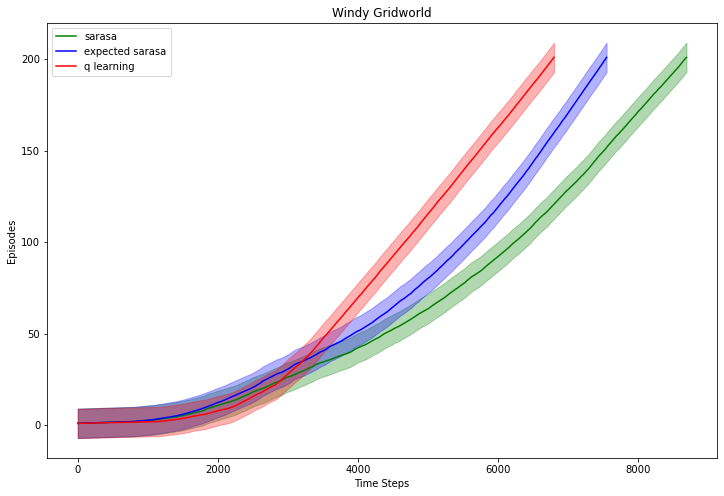

In [329]:
""" CODE HERE YOUR IMPLEMENTATION OF FIGURE PLOTTING """
plot_curves([cumulative_time_steps_sarsa, cumulative_time_steps_exp_sarsa, cumulative_time_steps_q_learning], ["sarasa","expected sarasa","q learning"], ["green","blue","red"], "Episodes", "Windy Gridworld")

# Q4 - (b): Re-solve the Windy GridWorld with Kings' movement and No movement.

Run trail:   0%|          | 0/10 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

Run trail:   0%|          | 0/10 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

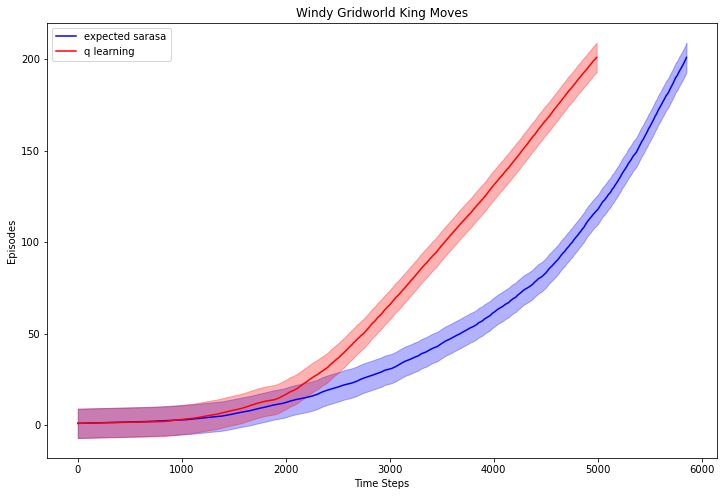

In [330]:
""" Reproduce the Figure above in Windy GridWorld with King's movement """
cts_ql_km, _ = q_learning(10,200, 0.5, 0.1, True, False)
cts_es_km,_ = expected_sarasa(10,200, 0.5, 0.1, True, False)
""" CODE HERE YOUR IMPLEMENTATION OF FIGURE PLOTTING """
plot_curves([cts_es_km, cts_ql_km], ["expected sarasa","q learning"], ["blue","red"], "Episodes", "Windy Gridworld King Moves")

Run trail:   0%|          | 0/10 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

Run trail:   0%|          | 0/10 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

run number:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

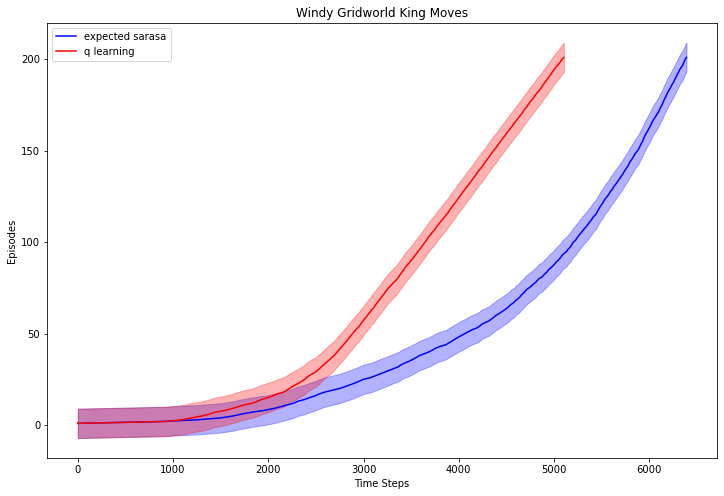

In [205]:
""" Reproduce the Figure above in Windy GridWorld with King's movement + no movement """
cts_ql_km_nm,_ = q_learning(10,200, 0.5, 0.1, True, True)
cts_es_km_nm,_ = expected_sarasa(10,200, 0.5, 0.1, True, True)
plot_curves([cts_es_km_nm, cts_ql_km_nm], ["expected sarasa","q learning"], ["blue","red"], "Episodes", "Windy Gridworld King Moves")

# Q5: Bias-variance trade-off

In [233]:
# Generates the episodes using the epsilon greedy version of the the provided Q values
def generate_episodes(Q, n_episodes):
    grid_world = WindyGridWorld()
    episodes = []
    for r in tqdm.tqdm(range(n_episodes), desc="run number", position=0):
        S, terminated = grid_world.reset()
        S = tuple(S)
        episode = []
        while True:
            # taking an epsilong greedy action wrt to the provided q values from state S
            A,_ = epsilon_greedy_policy_impl(S, Q, 0.1, list(grid_world.action_space.keys()), {})
            S_prime, R, terminated = grid_world.step(A)
            episode.append((S,A,R))
            if terminated:
                episode.append((tuple(S_prime),'none',0))
                break
            S = tuple(S_prime)
        episodes.append(episode)
    return episodes

In [303]:
# running state evaluation using TD for the given amount of episodes
def estimate_vs_td(episodes, step):
    V = {}
    grid_world = WindyGridWorld()
    for state in grid_world.state_space:
        if state == grid_world.goal_state:
            V[tuple(state)] = 0
        else:
            V[tuple(state)] = -5
    for r in tqdm.tqdm(range(len(episodes)), desc="run number", position=0):
        for i in range(len(episodes[r])-1):
            S, A, R = episodes[r][i]
            target = R + V[episodes[r][i+1][0]]
            V[S] += step*(target - V[S])
    return V

In [314]:
#Collect targets for TD with trained state values
def collect_targets_td(episodes, step, V):
    targets = []
    grid_world = WindyGridWorld()
    for r in tqdm.tqdm(range(len(episodes)), desc="run number", position=0):
        S, A, R = episodes[r][0]
        target = R + V[episodes[r][1][0]]
        targets.append(target)
    return targets

In [315]:
#Collect targets G for MC with trained state valuesfrom the evaluation episodes
def collect_targets_mc(episodes):
    # First, we initialize the empty value table as a dictionary for storing the values of each state
    V,N = {},{}
    targets = []
    grid_world = WindyGridWorld()
    for state in grid_world.state_space:
        V[tuple(state)] = -10
        N[tuple(state)] = 0
    for r in tqdm.tqdm(range(len(episodes)), desc="run number", position=0):
        G = 0
        for k in range(len(episodes[r]) - 2, -1, -1):
            S, A, R = episodes[r][k]
            # calculating the returns until time step k in episode
            G += R
            append = True
            # running first visit MC
            for l in range(k):
                s = episodes[r][k][0]
                if s == S:
                    append = False
            if append:
                N[S] +=1
                V[S] += (G - V[S]) / N[S]
                if S == tuple(grid_world.start_state):
                    targets.append(G)
    return targets

In [316]:
def off_policy_training(episodes, step):
    grid_world = WindyGridWorld()
    Q = defaultdict(float)
    policy = {}
    for state in grid_world.state_space:
        for action in grid_world.action_space:
            if state == grid_world.goal_state:
                Q[tuple(state) , action] = 0
            else:
                Q[tuple(state), action] = -50
    for r in tqdm.tqdm(range(len(episodes)), desc="run number", position=0):
        for i in range(len(episodes[r])-1):    
            S, A, R = episodes[r][i]
            S_prime = episodes[r][i+1][0]
            A_max,_ = epsilon_greedy_policy_impl(S_prime, Q, 0, list(grid_world.action_space.keys()), policy)
            Q[S, A] += step*(R + Q[S_prime, A_max] - Q[S, A])
            S = S_prime
    return Q

In [317]:
# running policy evaluation using dynamic programming for the epsilon greedy version of the provided q values
def policy_evaluation_dynamic(Q):
    frequency = defaultdict(float)
    threshold = 1e-2
    policy, V = {}, {}
    # random initialization of the values
    grid_world = WindyGridWorld()
    for state in grid_world.state_space:
        if state == grid_world.goal_state:
            V[tuple(state)] = 0
        else:
            V[tuple(state)] = random.randint(-20,-15)
    while True:
        is_optimal = True
        for S in grid_world.state_space:
            if S != grid_world.goal_state:
                S = tuple(S)
                old_v = V[S]
                # setting the policy's probability for every action from state S
                _,_ = epsilon_greedy_policy_impl(S, Q, 0.1, list(grid_world.action_space.keys()), policy)
                new_v = 0
                # calculating the expecation of V(S') under provided policy
                for A in policy[S]:
                    grid_world.reset()
                    grid_world.state = list(S)
                    S_prime, R , termination = grid_world.step(A)
                    new_v += policy[S][A]*(R + V[tuple(S_prime)])
                # Breaking value iteration when the difference is less than threshold
                if abs(old_v-new_v) > threshold or not is_optimal:
                    is_optimal = False
                else:
                    is_optimal = True
                V[S] = new_v
        if is_optimal:
            break
    return V[tuple(grid_world.start_state)]

In [318]:
# Runs value iteration for finding the true value of the states in the grid worls
def value_iteration():
    frequency = defaultdict(float)
    threshold = 1e-2
    policy, V = {}, {}
    grid_world = WindyGridWorld()
    # randomly initializing V
    for state in grid_world.state_space:
        if state == grid_world.goal_state:
            V[tuple(state)] = 0
        else:
            V[tuple(state)] = random.randint(-20,-15)
    while True:
        is_optimal = True
        for S in grid_world.state_space:
            if S != grid_world.goal_state:
                S = tuple(S)
                old_v = V[S]
                new_v = float('-inf')
                # setting V(S) to the max V(s')
                for A in grid_world.action_space:
                    grid_world.reset()
                    grid_world.state = list(S)
                    S_prime, R , termination = grid_world.step(A)
                    v = R + V[tuple(S_prime)]
                    if v > new_v:
                        new_v = v
                # Breaking value iteration when the difference is less than threshold
                if abs(old_v-new_v) > threshold or not is_optimal:
                    is_optimal = False
                else:
                    is_optimal = True
                V[S] = new_v
        if is_optimal:
            break
    return V[tuple(grid_world.start_state)]

In [319]:
_, q_optimal = q_learning(1, 300, 0.5, 0.1, False, False)

print("Episode Generation for N = 1")
training_episodes_one = generate_episodes(q_optimal, 1)
print("Episode Generation for N = 10")
training_episodes_ten = generate_episodes(q_optimal, 10)
print("Episode Generation for N = 50")
training_episodes_fifty = generate_episodes(q_optimal, 50)

print("Collecting evaluation episodes")
evaluation_episodes = generate_episodes(q_optimal, 100)
                                              
print("Finding true value of Vpi(S)")
V_S = value_iteration()
                                              
# print("Training off policy for N=1 using td")
vs_td_one = estimate_vs_td(training_episodes_one, 0.5)         
print("Training off policy for N=10 using td")
vs_td_ten = estimate_vs_td(training_episodes_ten, 0.5) 
print("Training off policy for N=50 using td")
vs_td_fifty = estimate_vs_td(training_episodes_fifty, 0.5) 


print("Value estimation for One episode with TD")
targets_one_td = collect_targets_td(evaluation_episodes, 0.5, vs_td_one)
print("Value estimation for Ten episode with TD")
targets_ten_td = collect_targets_td(evaluation_episodes, 0.5, vs_td_ten)
print("Value estimation for Fifty episode with TD")
targets_fifty_td = collect_targets_td(evaluation_episodes, 0.5, vs_td_fifty)
print("Value estimation for episodes with MC")
targets_mc = collect_targets_mc(evaluation_episodes)

Run trail:   0%|          | 0/1 [00:00<?, ?it/s]

run number:   0%|          | 0/300 [00:00<?, ?it/s]

Episode Generation for N = 1


run number:   0%|          | 0/1 [00:00<?, ?it/s]

Episode Generation for N = 10


run number:   0%|          | 0/10 [00:00<?, ?it/s]

Episode Generation for N = 50


run number:   0%|          | 0/50 [00:00<?, ?it/s]

run number:   0%|          | 0/100 [00:00<?, ?it/s]

Finding true value of Vpi(S)


run number:   0%|          | 0/1 [00:00<?, ?it/s]

Training off policy for N=10 using td


run number:   0%|          | 0/10 [00:00<?, ?it/s]

Training off policy for N=50 using td


run number:   0%|          | 0/50 [00:00<?, ?it/s]

Value estimation for One episode with TD


run number:   0%|          | 0/100 [00:00<?, ?it/s]

Value estimation for Ten episode with TD


run number:   0%|          | 0/100 [00:00<?, ?it/s]

Value estimation for Fifty episode with TD


run number:   0%|          | 0/100 [00:00<?, ?it/s]

Value estimation for episodes with MC


run number:   0%|          | 0/100 [00:00<?, ?it/s]

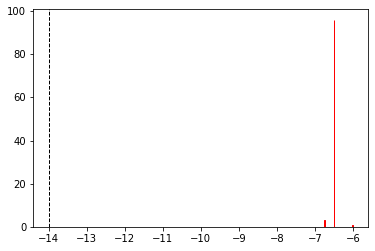

std deviation for N=1 TD 0.06609652033201142


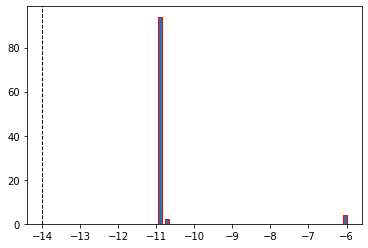

std deviation for N=1 TD 0.9713490056423228


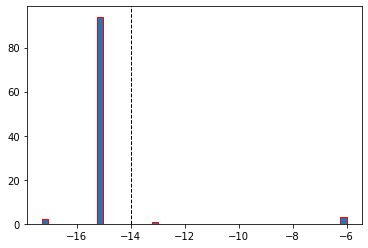

std deviation for N=1 TD 1.5935554020580673


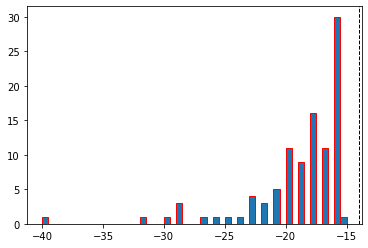

std deviation for N=1 MC 4.087480886805467


In [320]:
plt.hist(targets_one_td, edgecolor="red", bins=50)
plt.axvline(V_S, color='k', linestyle='dashed', linewidth=1)
plt.show()
print("std deviation for N=1 TD",np.std(targets_one_td))
plt.hist(targets_ten_td, edgecolor="red", bins=50)
plt.axvline(V_S, color='k', linestyle='dashed', linewidth=1)
plt.show()
print("std deviation for N=1 TD",np.std(targets_ten_td))
plt.hist(targets_fifty_td, edgecolor="red", bins=50)
plt.axvline(V_S, color='k', linestyle='dashed', linewidth=1)
plt.show()
print("std deviation for N=1 TD",np.std(targets_fifty_td))
plt.hist(targets_mc, edgecolor="red", bins=50)
plt.axvline(V_S, color='k', linestyle='dashed', linewidth=1)
plt.show()
print("std deviation for N=1 MC",np.std(targets_mc))